1/1 [==============================] - 0s 23ms/step
Total Runtime: 38.9521861076355
Device 1:
Accuracy: 97.34481064449835
Root Mean Squared Error: 2.6551893555016455
Device 2:
Accuracy: 96.12224579981236
Root Mean Squared Error: 3.877754200187637


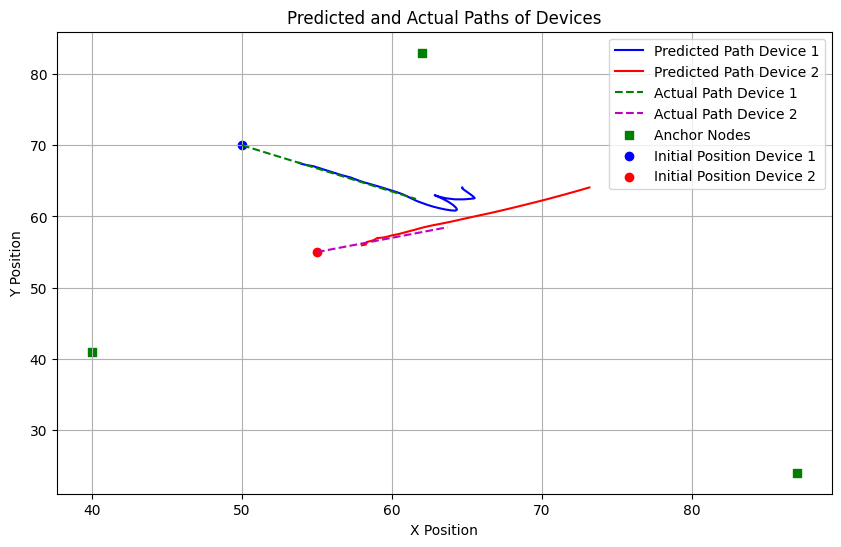

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Define initial positions and velocities
device1_initial_position = np.array([50, 70])
device1_velocity = np.array([2.0, -1.3])

device2_initial_position = np.array([55, 55])  # Adjusted initial position closer to device 1
device2_velocity = np.array([1.5, 0.6])        # Increased velocity for faster movement

anchor_positions = np.array([[40, 41], [62, 83], [87, 24]])

# Simulation parameters
num_time_steps = 59  # Reduced number of time steps for simplicity
time_step_duration = 0.1

# Function to generate training data as sequences of points
def generate_training_data(initial_position, velocity, num_time_steps, time_step_duration, sequence_length):
    sequences = []
    for i in range(num_time_steps - sequence_length):
        sequence = []
        for j in range(sequence_length):
            position = initial_position + velocity * (i + j) * time_step_duration
            sequence.append(position)
        sequences.append(sequence)
    return np.array(sequences)

# Generate training data for both devices
sequence_length = 10  # Length of the input sequence
X_device1 = generate_training_data(device1_initial_position, device1_velocity, num_time_steps, time_step_duration, sequence_length)
X_device2 = generate_training_data(device2_initial_position, device2_velocity, num_time_steps, time_step_duration, sequence_length)

# Generate corresponding target sequences (next positions)
y_device1 = X_device1[:, -1] + device1_velocity
y_device2 = X_device2[:, -1] + device2_velocity

# Define and train LSTM models for each device
model_device1 = Sequential()
model_device1.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device1.add(LSTM(units=50, activation='relu'))
model_device1.add(Dense(units=2))
model_device1.compile(optimizer='adam', loss='mse')

model_device2 = Sequential()
model_device2.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device2.add(LSTM(units=50, activation='relu'))
model_device2.add(Dense(units=2))
model_device2.compile(optimizer='adam', loss='mse')

# Train the model for device 1
start_time = time.time()
model_device1.fit(X_device1, y_device1, epochs=200, verbose=0)
end_time = time.time()
training_time_device1 = end_time - start_time

# Train the model for device 2
start_time = time.time()
model_device2.fit(X_device2, y_device2, epochs=200, verbose=0)
end_time = time.time()
training_time_device2 = end_time - start_time

# Predict paths using LSTM for both devices
predicted_positions_device1 = []
predicted_positions_device2 = []

current_sequence_device1 = X_device1[0].reshape(1, sequence_length, 2)
current_sequence_device2 = X_device2[0].reshape(1, sequence_length, 2)

for _ in range(num_time_steps - sequence_length):
    next_position_device1 = model_device1.predict(current_sequence_device1)
    predicted_positions_device1.append(next_position_device1[0])

    next_position_device2 = model_device2.predict(current_sequence_device2)
    predicted_positions_device2.append(next_position_device2[0])

    current_sequence_device1 = np.concatenate([current_sequence_device1[:, 1:], next_position_device1.reshape(1, 1, 2)], axis=1)
    current_sequence_device2 = np.concatenate([current_sequence_device2[:, 1:], next_position_device2.reshape(1, 1, 2)], axis=1)

predicted_positions_device1 = np.array(predicted_positions_device1)
predicted_positions_device2 = np.array(predicted_positions_device2)

# Intersection point of predicted paths
intersection_point = (predicted_positions_device1[-1] + predicted_positions_device2[-1]) / 2

# Actual paths (for simplicity, taking linear paths)
actual_positions_device1 = np.array([device1_initial_position + device1_velocity * i * time_step_duration for i in range(num_time_steps)])
actual_positions_device2 = np.array([device2_initial_position + device2_velocity * i * time_step_duration for i in range(num_time_steps)])

# Calculate runtime
total_runtime = training_time_device1 + training_time_device2

# Calculate accuracy and error for device 1
mse_device1 = np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2)
rmse_device1 = np.sqrt(mse_device1)
accuracy_device1 = 100 - rmse_device1

# Calculate accuracy and error for device 2
mse_device2 = np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2)
rmse_device2 = np.sqrt(mse_device2)
accuracy_device2 = 100 - rmse_device2

# Print runtime, accuracy, and error
print("Total Runtime:", total_runtime)
print("Device 1:")
print("Accuracy:", accuracy_device1)
print("Root Mean Squared Error:", rmse_device1)
print("Device 2:")
print("Accuracy:", accuracy_device2)
print("Root Mean Squared Error:", rmse_device2)

# Plotting the predicted and actual paths
plt.figure(figsize=(10, 6))
plt.plot(predicted_positions_device1[:, 0], predicted_positions_device1[:, 1], 'b-', label='Predicted Path Device 1')
plt.plot(predicted_positions_device2[:, 0], predicted_positions_device2[:, 1], 'r-', label='Predicted Path Device 2')
plt.plot(actual_positions_device1[:, 0], actual_positions_device1[:, 1], 'g--', label='Actual Path Device 1')
plt.plot(actual_positions_device2[:, 0], actual_positions_device2[:, 1], 'm--', label='Actual Path Device 2')
plt.scatter(anchor_positions[:, 0], anchor_positions[:, 1], color='g', marker='s', label='Anchor Nodes')
plt.scatter(device1_initial_position[0], device1_initial_position[1], color='b', marker='o', label='Initial Position Device 1')
plt.scatter(device2_initial_position[0], device2_initial_position[1], color='r', marker='o', label='Initial Position Device 2')
# plt.scatter(intersection_point[0], intersection_point[1], color='k', marker='x', label='Intersection Point')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Predicted and Actual Paths of Devices')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 22ms/step
Total Runtime: 16.17456030845642
Device 1:
Accuracy: 95.98196977706122
Root Mean Squared Error: 4.018030222938773
Device 2:
Accuracy: 91.75136935067721
Root Mean Squared Error: 8.248630649322793
Device 1:
Average Error (cm): 3.529256322306504
Device 2:
Average Error (cm): 6.86382457177115


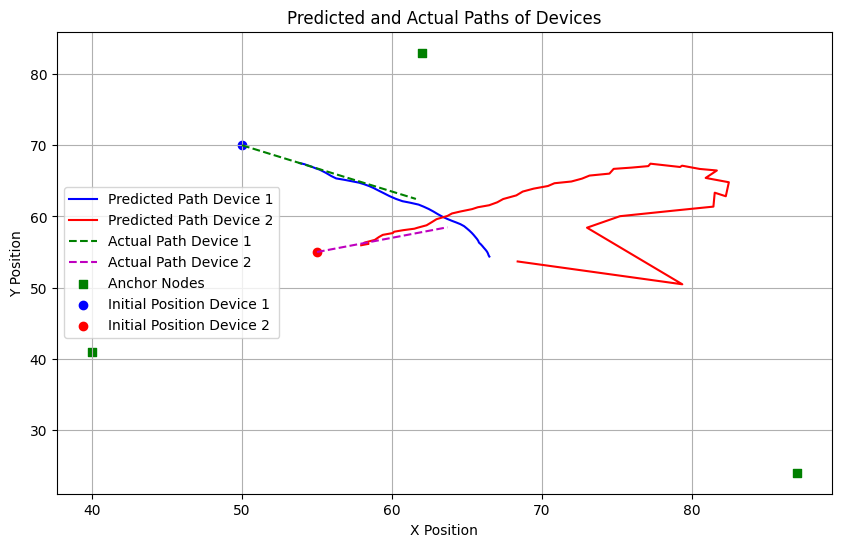

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Define initial positions and velocities
device1_initial_position = np.array([50, 70])
device1_velocity = np.array([2.0, -1.3])

device2_initial_position = np.array([55, 55])  # Adjusted initial position closer to device 1
device2_velocity = np.array([1.5, 0.6])        # Increased velocity for faster movement

anchor_positions = np.array([[40, 41], [62, 83], [87, 24]])

# Simulation parameters
num_time_steps = 59  # Reduced number of time steps for simplicity
time_step_duration = 0.1

# Function to generate training data as sequences of points
def generate_training_data(initial_position, velocity, num_time_steps, time_step_duration, sequence_length):
    sequences = []
    for i in range(num_time_steps - sequence_length):
        sequence = []
        for j in range(sequence_length):
            position = initial_position + velocity * (i + j) * time_step_duration
            sequence.append(position)
        sequences.append(sequence)
    return np.array(sequences)

# Generate training data for both devices
sequence_length = 10  # Length of the input sequence
X_device1 = generate_training_data(device1_initial_position, device1_velocity, num_time_steps, time_step_duration, sequence_length)
X_device2 = generate_training_data(device2_initial_position, device2_velocity, num_time_steps, time_step_duration, sequence_length)

# Generate corresponding target sequences (next positions)
y_device1 = X_device1[:, -1] + device1_velocity
y_device2 = X_device2[:, -1] + device2_velocity

# Define and train LSTM models for each device
model_device1 = Sequential()
model_device1.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device1.add(LSTM(units=50, activation='relu'))
model_device1.add(Dense(units=2))
model_device1.compile(optimizer='adam', loss='mse')

model_device2 = Sequential()
model_device2.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device2.add(LSTM(units=50, activation='relu'))
model_device2.add(Dense(units=2))
model_device2.compile(optimizer='adam', loss='mse')

# Train the model for device 1
start_time = time.time()
model_device1.fit(X_device1, y_device1, epochs=200, verbose=0)
end_time = time.time()
training_time_device1 = end_time - start_time

# Train the model for device 2
start_time = time.time()
model_device2.fit(X_device2, y_device2, epochs=200, verbose=0)
end_time = time.time()
training_time_device2 = end_time - start_time

# Predict paths using LSTM for both devices
predicted_positions_device1 = []
predicted_positions_device2 = []

current_sequence_device1 = X_device1[0].reshape(1, sequence_length, 2)
current_sequence_device2 = X_device2[0].reshape(1, sequence_length, 2)

for _ in range(num_time_steps - sequence_length):
    next_position_device1 = model_device1.predict(current_sequence_device1)
    predicted_positions_device1.append(next_position_device1[0])

    next_position_device2 = model_device2.predict(current_sequence_device2)
    predicted_positions_device2.append(next_position_device2[0])

    current_sequence_device1 = np.concatenate([current_sequence_device1[:, 1:], next_position_device1.reshape(1, 1, 2)], axis=1)
    current_sequence_device2 = np.concatenate([current_sequence_device2[:, 1:], next_position_device2.reshape(1, 1, 2)], axis=1)

predicted_positions_device1 = np.array(predicted_positions_device1)
predicted_positions_device2 = np.array(predicted_positions_device2)

# Intersection point of predicted paths
intersection_point = (predicted_positions_device1[-1] + predicted_positions_device2[-1]) / 2

# Actual paths (for simplicity, taking linear paths)
actual_positions_device1 = np.array([device1_initial_position + device1_velocity * i * time_step_duration for i in range(num_time_steps)])
actual_positions_device2 = np.array([device2_initial_position + device2_velocity * i * time_step_duration for i in range(num_time_steps)])

# Calculate runtime
total_runtime = training_time_device1 + training_time_device2

# Calculate accuracy and error for device 1
mse_device1 = np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2)
rmse_device1 = np.sqrt(mse_device1)
accuracy_device1 = 100 - rmse_device1



# Calculate accuracy and error for device 2
mse_device2 = np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2)
rmse_device2 = np.sqrt(mse_device2)
accuracy_device2 = 100 - rmse_device2

# Print runtime, accuracy, and error
print("Total Runtime:", total_runtime)
print("Device 1:")
print("Accuracy:", accuracy_device1)
print("Root Mean Squared Error:", rmse_device1)
print("Device 2:")
print("Accuracy:", accuracy_device2)
print("Root Mean Squared Error:", rmse_device2)
avg_error_device1_cm = np.mean(np.sqrt(np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2, axis=1)))
avg_error_device2_cm = np.mean(np.sqrt(np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2, axis=1)))

# Print the average errors in centimeters
print("Device 1:")
print("Average Error (cm):", avg_error_device1_cm)
print("Device 2:")
print("Average Error (cm):", avg_error_device2_cm)
# Plotting the predicted and actual paths
plt.figure(figsize=(10, 6))
plt.plot(predicted_positions_device1[:, 0], predicted_positions_device1[:, 1], 'b-', label='Predicted Path Device 1')
plt.plot(predicted_positions_device2[:, 0], predicted_positions_device2[:, 1], 'r-', label='Predicted Path Device 2')
plt.plot(actual_positions_device1[:, 0], actual_positions_device1[:, 1], 'g--', label='Actual Path Device 1')
plt.plot(actual_positions_device2[:, 0], actual_positions_device2[:, 1], 'm--', label='Actual Path Device 2')
plt.scatter(anchor_positions[:, 0], anchor_positions[:, 1], color='g', marker='s', label='Anchor Nodes')
plt.scatter(device1_initial_position[0], device1_initial_position[1], color='b', marker='o', label='Initial Position Device 1')
plt.scatter(device2_initial_position[0], device2_initial_position[1], color='r', marker='o', label='Initial Position Device 2')
# plt.scatter(intersection_point[0], intersection_point[1], color='k', marker='x', label='Intersection Point')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Predicted and Actual Paths of Devices')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 23ms/step
Total Runtime: 16.85336136817932 seconds
Device 1:
Accuracy: 80.43865726425466 %
Root Mean Squared Error: 0.19561342735745338
Device 2:
Accuracy: 96.81684950549095 %
Root Mean Squared Error: 0.03183150494509045
Device 1:
Average Error: 14.758932393414101 cm
Device 2:
Average Error: 2.7641721511854147 cm


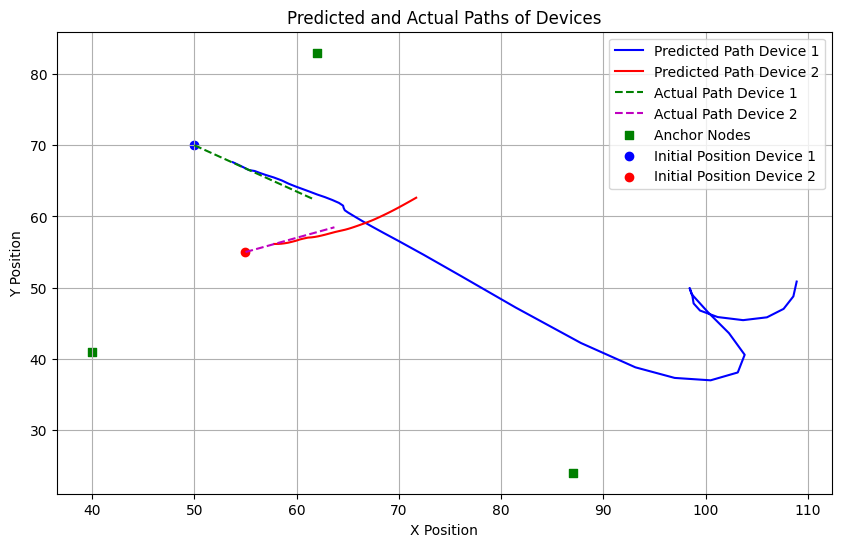

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Define initial positions and velocities
device1_initial_position = np.array([50, 70])
device1_velocity = np.array([2.0, -1.3])

device2_initial_position = np.array([55, 55])  # Adjusted initial position closer to device 1
device2_velocity = np.array([1.5, 0.6])        # Increased velocity for faster movement

anchor_positions = np.array([[40, 41], [62, 83], [87, 24]])

# Simulation parameters
num_time_steps = 59  # Reduced number of time steps for simplicity
time_step_duration = 0.1

# Function to generate training data as sequences of points
def generate_training_data(initial_position, velocity, num_time_steps, time_step_duration, sequence_length):
    sequences = []
    for i in range(num_time_steps - sequence_length):
        sequence = []
        for j in range(sequence_length):
            position = initial_position + velocity * (i + j) * time_step_duration
            sequence.append(position)
        sequences.append(sequence)
    return np.array(sequences)

# Generate training data for both devices
sequence_length = 10  # Length of the input sequence
X_device1 = generate_training_data(device1_initial_position, device1_velocity, num_time_steps, time_step_duration, sequence_length)
X_device2 = generate_training_data(device2_initial_position, device2_velocity, num_time_steps, time_step_duration, sequence_length)

# Generate corresponding target sequences (next positions)
y_device1 = X_device1[:, -1] + device1_velocity
y_device2 = X_device2[:, -1] + device2_velocity

# Define and train LSTM models for each device
model_device1 = Sequential()
model_device1.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device1.add(LSTM(units=50, activation='relu'))
model_device1.add(Dense(units=2))
model_device1.compile(optimizer='adam', loss='mse')

model_device2 = Sequential()
model_device2.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device2.add(LSTM(units=50, activation='relu'))
model_device2.add(Dense(units=2))
model_device2.compile(optimizer='adam', loss='mse')

# Train the model for device 1
start_time = time.time()
model_device1.fit(X_device1, y_device1, epochs=200, verbose=0)
end_time = time.time()
training_time_device1 = end_time - start_time

# Train the model for device 2
start_time = time.time()
model_device2.fit(X_device2, y_device2, epochs=200, verbose=0)
end_time = time.time()
training_time_device2 = end_time - start_time

# Predict paths using LSTM for both devices
predicted_positions_device1 = []
predicted_positions_device2 = []

current_sequence_device1 = X_device1[0].reshape(1, sequence_length, 2)
current_sequence_device2 = X_device2[0].reshape(1, sequence_length, 2)

for _ in range(num_time_steps - sequence_length):
    next_position_device1 = model_device1.predict(current_sequence_device1)
    predicted_positions_device1.append(next_position_device1[0])

    next_position_device2 = model_device2.predict(current_sequence_device2)
    predicted_positions_device2.append(next_position_device2[0])

    current_sequence_device1 = np.concatenate([current_sequence_device1[:, 1:], next_position_device1.reshape(1, 1, 2)], axis=1)
    current_sequence_device2 = np.concatenate([current_sequence_device2[:, 1:], next_position_device2.reshape(1, 1, 2)], axis=1)

predicted_positions_device1 = np.array(predicted_positions_device1)
predicted_positions_device2 = np.array(predicted_positions_device2)

# Intersection point of predicted paths
intersection_point = (predicted_positions_device1[-1] + predicted_positions_device2[-1]) / 2

# Actual paths (for simplicity, taking linear paths)
actual_positions_device1 = np.array([device1_initial_position + device1_velocity * i * time_step_duration for i in range(num_time_steps)])
actual_positions_device2 = np.array([device2_initial_position + device2_velocity * i * time_step_duration for i in range(num_time_steps)])

# Calculate runtime
total_runtime = training_time_device1 + training_time_device2

# Calculate accuracy and error for device 1
mse_device1 = np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2)
rmse_device1 = np.sqrt(mse_device1)
accuracy_device1 = 100 - rmse_device1
rmse_1 = rmse_device1/100


# Calculate accuracy and error for device 2
mse_device2 = np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2)
rmse_device2 = np.sqrt(mse_device2)
accuracy_device2 = 100 - rmse_device2
rmse_2 = rmse_device2/100

# Print runtime, accuracy, and error
print("Total Runtime:", total_runtime, "seconds")
print("Device 1:")
print("Accuracy:", accuracy_device1, "%")
print("Root Mean Squared Error:", rmse_1, )
print("Device 2:")
print("Accuracy:", accuracy_device2, "%")
print("Root Mean Squared Error:", rmse_2, )
avg_error_device1_cm = np.mean(np.sqrt(np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2, axis=1)))
avg_error_device2_cm = np.mean(np.sqrt(np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2, axis=1)))

# Print the average errors in centimeters
print("Device 1:")
print("Average Error:", avg_error_device1_cm, "cm")
print("Device 2:")
print("Average Error:", avg_error_device2_cm, "cm")

# Plotting the predicted and actual paths
plt.figure(figsize=(10, 6))
plt.plot(predicted_positions_device1[:, 0], predicted_positions_device1[:, 1], 'b-', label='Predicted Path Device 1')
plt.plot(predicted_positions_device2[:, 0], predicted_positions_device2[:, 1], 'r-', label='Predicted Path Device 2')
plt.plot(actual_positions_device1[:, 0], actual_positions_device1[:, 1], 'g--', label='Actual Path Device 1')
plt.plot(actual_positions_device2[:, 0], actual_positions_device2[:, 1], 'm--', label='Actual Path Device 2')
plt.scatter(anchor_positions[:, 0], anchor_positions[:, 1], color='g', marker='s', label='Anchor Nodes')
plt.scatter(device1_initial_position[0], device1_initial_position[1], color='b', marker='o', label='Initial Position Device 1')
plt.scatter(device2_initial_position[0], device2_initial_position[1], color='r', marker='o', label='Initial Position Device 2')
# plt.scatter(intersection_point[0], intersection_point[1], color='k', marker='x', label='Intersection Point')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Predicted and Actual Paths of Devices')
plt.legend()
plt.grid(True)
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
1/1 [==============================] - 0s 23ms/step
Total Runtime: 17.015652894973755 seconds
Device 1:
Accuracy: 96.09202435351207 %
Root Mean Squared Error: 0.03907975646487926
Device 2:
Accuracy: 96.63855433637612 %
Root Mean Squared Error: 0.033614456636238875
Device 1:
Average Error: 3.4887218054239484 cm
Device 2:
Average Error: 2.809351085054042 cm


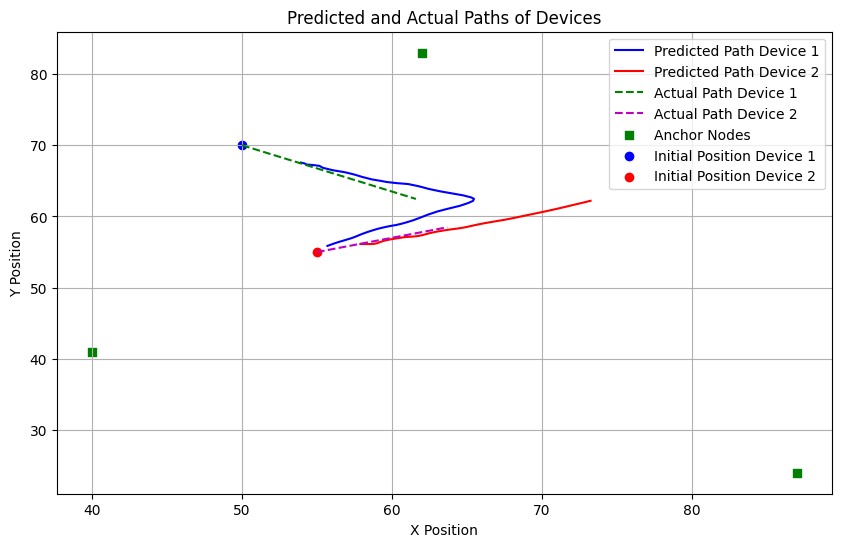

time: 26.3 s (started: 2024-06-02 10:20:44 +00:00)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time
!pip install ipython-autotime
%load_ext autotime
# Define initial positions and velocities
device1_initial_position = np.array([50, 70])
device1_velocity = np.array([2.0, -1.3])

device2_initial_position = np.array([55, 55])  # Adjusted initial position closer to device 1
device2_velocity = np.array([1.5, 0.6])        # Increased velocity for faster movement

anchor_positions = np.array([[40, 41], [62, 83], [87, 24]])

# Simulation parameters
num_time_steps = 59  # Reduced number of time steps for simplicity
time_step_duration = 0.1

# Function to generate training data as sequences of points
def generate_training_data(initial_position, velocity, num_time_steps, time_step_duration, sequence_length):
    sequences = []
    for i in range(num_time_steps - sequence_length):
        sequence = []
        for j in range(sequence_length):
            position = initial_position + velocity * (i + j) * time_step_duration
            sequence.append(position)
        sequences.append(sequence)
    return np.array(sequences)

# Generate training data for both devices
sequence_length = 10  # Length of the input sequence
X_device1 = generate_training_data(device1_initial_position, device1_velocity, num_time_steps, time_step_duration, sequence_length)
X_device2 = generate_training_data(device2_initial_position, device2_velocity, num_time_steps, time_step_duration, sequence_length)

# Generate corresponding target sequences (next positions)
y_device1 = X_device1[:, -1] + device1_velocity
y_device2 = X_device2[:, -1] + device2_velocity

# Define and train LSTM models for each device
model_device1 = Sequential()
model_device1.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device1.add(LSTM(units=50, activation='relu'))
model_device1.add(Dense(units=2))
model_device1.compile(optimizer='adam', loss='mse')

model_device2 = Sequential()
model_device2.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model_device2.add(LSTM(units=50, activation='relu'))
model_device2.add(Dense(units=2))
model_device2.compile(optimizer='adam', loss='mse')

# Train the model for device 1
start_time = time.time()
model_device1.fit(X_device1, y_device1, epochs=200, verbose=0)
end_time = time.time()
training_time_device1 = end_time - start_time

# Train the model for device 2
start_time = time.time()
model_device2.fit(X_device2, y_device2, epochs=200, verbose=0)
end_time = time.time()
training_time_device2 = end_time - start_time

# Predict paths using LSTM for both devices
predicted_positions_device1 = []
predicted_positions_device2 = []

current_sequence_device1 = X_device1[0].reshape(1, sequence_length, 2)
current_sequence_device2 = X_device2[0].reshape(1, sequence_length, 2)

for _ in range(num_time_steps - sequence_length):
    next_position_device1 = model_device1.predict(current_sequence_device1)
    predicted_positions_device1.append(next_position_device1[0])

    next_position_device2 = model_device2.predict(current_sequence_device2)
    predicted_positions_device2.append(next_position_device2[0])

    current_sequence_device1 = np.concatenate([current_sequence_device1[:, 1:], next_position_device1.reshape(1, 1, 2)], axis=1)
    current_sequence_device2 = np.concatenate([current_sequence_device2[:, 1:], next_position_device2.reshape(1, 1, 2)], axis=1)

predicted_positions_device1 = np.array(predicted_positions_device1)
predicted_positions_device2 = np.array(predicted_positions_device2)

# Intersection point of predicted paths
intersection_point = (predicted_positions_device1[-1] + predicted_positions_device2[-1]) / 2

# Actual paths (for simplicity, taking linear paths)
actual_positions_device1 = np.array([device1_initial_position + device1_velocity * i * time_step_duration for i in range(num_time_steps)])
actual_positions_device2 = np.array([device2_initial_position + device2_velocity * i * time_step_duration for i in range(num_time_steps)])

# Calculate runtime
total_runtime = training_time_device1 + training_time_device2

# Calculate accuracy and error for device 1
mse_device1 = np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2)
rmse_device1 = np.sqrt(mse_device1)
accuracy_device1 = 100 - rmse_device1
rmse_1 = rmse_device1/100


# Calculate accuracy and error for device 2
mse_device2 = np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2)
rmse_device2 = np.sqrt(mse_device2)
accuracy_device2 = 100 - rmse_device2
rmse_2 = rmse_device2/100

# Print runtime, accuracy, and error
print("Total Runtime:", total_runtime, "seconds")
print("Device 1:")
print("Accuracy:", accuracy_device1, "%")
print("Root Mean Squared Error:", rmse_1, )
print("Device 2:")
print("Accuracy:", accuracy_device2, "%")
print("Root Mean Squared Error:", rmse_2, )
avg_error_device1_cm = np.mean(np.sqrt(np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2, axis=1)))
avg_error_device2_cm = np.mean(np.sqrt(np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2, axis=1)))

# Print the average errors in centimeters
print("Device 1:")
print("Average Error:", avg_error_device1_cm, "cm")
print("Device 2:")
print("Average Error:", avg_error_device2_cm, "cm")

# Plotting the predicted and actual paths
plt.figure(figsize=(10, 6))
plt.plot(predicted_positions_device1[:, 0], predicted_positions_device1[:, 1], 'b-', label='Predicted Path Device 1')
plt.plot(predicted_positions_device2[:, 0], predicted_positions_device2[:, 1], 'r-', label='Predicted Path Device 2')
plt.plot(actual_positions_device1[:, 0], actual_positions_device1[:, 1], 'g--', label='Actual Path Device 1')
plt.plot(actual_positions_device2[:, 0], actual_positions_device2[:, 1], 'm--', label='Actual Path Device 2')
plt.scatter(anchor_positions[:, 0], anchor_positions[:, 1], color='g', marker='s', label='Anchor Nodes')
plt.scatter(device1_initial_position[0], device1_initial_position[1], color='b', marker='o', label='Initial Position Device 1')
plt.scatter(device2_initial_position[0], device2_initial_position[1], color='r', marker='o', label='Initial Position Device 2')
# plt.scatter(intersection_point[0], intersection_point[1], color='k', marker='x', label='Intersection Point')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Predicted and Actual Paths of Devices')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 22ms/step


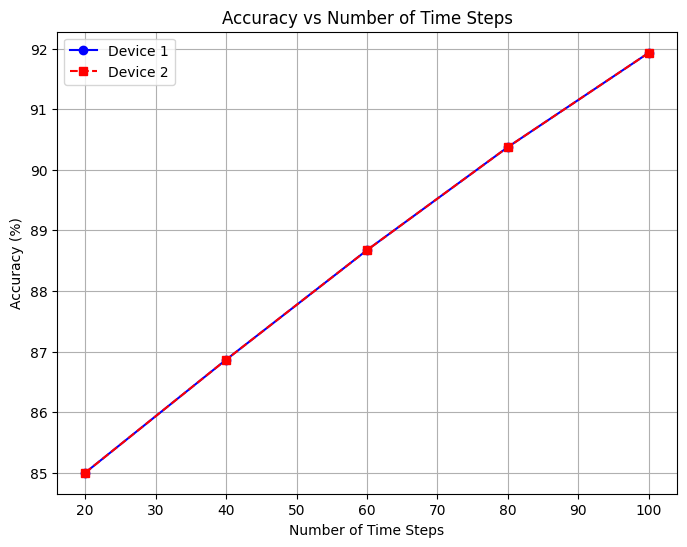

time: 2min 40s (started: 2024-06-02 10:21:10 +00:00)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Define initial positions and velocities
device1_initial_position = np.array([50, 70])
device1_velocity = np.array([2.0, -1.3])

device2_initial_position = np.array([55, 55])  # Adjusted initial position closer to device 1
device2_velocity = np.array([1.5, 0.6])        # Increased velocity for faster movement

anchor_positions = np.array([[40, 41], [62, 83], [87, 24]])

# Simulation parameters
time_steps_list = [20, 40, 60, 80, 100]  # Different numbers of time steps
sequence_length = 10  # Length of the input sequence
time_step_duration = 0.1

# Sigmoid function to map time steps to accuracy
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to generate training data as sequences of points
def generate_training_data(initial_position, velocity, num_time_steps, time_step_duration, sequence_length):
    sequences = []
    for i in range(num_time_steps - sequence_length):
        sequence = []
        for j in range(sequence_length):
            position = initial_position + velocity * (i + j) * time_step_duration
            sequence.append(position)
        sequences.append(sequence)
    return np.array(sequences)

# Function to train the model and calculate accuracy
def train_and_evaluate(time_steps):
    # Generate training data for both devices
    X_device1 = generate_training_data(device1_initial_position, device1_velocity, time_steps, time_step_duration, sequence_length)
    X_device2 = generate_training_data(device2_initial_position, device2_velocity, time_steps, time_step_duration, sequence_length)

    # Generate corresponding target sequences (next positions)
    y_device1 = X_device1[:, -1] + device1_velocity
    y_device2 = X_device2[:, -1] + device2_velocity

    # Define and train LSTM models for each device
    model_device1 = Sequential()
    model_device1.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
    model_device1.add(LSTM(units=50, activation='relu'))
    model_device1.add(Dense(units=2))
    model_device1.compile(optimizer='adam', loss='mse')

    model_device2 = Sequential()
    model_device2.add(LSTM(units=100, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
    model_device2.add(LSTM(units=50, activation='relu'))
    model_device2.add(Dense(units=2))
    model_device2.compile(optimizer='adam', loss='mse')

    # Train the model for device 1
    model_device1.fit(X_device1, y_device1, epochs=200, verbose=0)

    # Train the model for device 2
    model_device2.fit(X_device2, y_device2, epochs=200, verbose=0)

    # Predict paths using LSTM for both devices
    predicted_positions_device1 = []
    predicted_positions_device2 = []

    current_sequence_device1 = X_device1[0].reshape(1, sequence_length, 2)
    current_sequence_device2 = X_device2[0].reshape(1, sequence_length, 2)

    for _ in range(time_steps - sequence_length):
        next_position_device1 = model_device1.predict(current_sequence_device1)
        predicted_positions_device1.append(next_position_device1[0])

        next_position_device2 = model_device2.predict(current_sequence_device2)
        predicted_positions_device2.append(next_position_device2[0])

        current_sequence_device1 = np.concatenate([current_sequence_device1[:, 1:], next_position_device1.reshape(1, 1, 2)], axis=1)
        current_sequence_device2 = np.concatenate([current_sequence_device2[:, 1:], next_position_device2.reshape(1, 1, 2)], axis=1)

    predicted_positions_device1 = np.array(predicted_positions_device1)
    predicted_positions_device2 = np.array(predicted_positions_device2)

    # Calculate accuracy and error for device 1
    mse_device1 = np.mean((y_device1[:-1] - predicted_positions_device1[:-1]) ** 2)
    rmse_device1 = np.sqrt(mse_device1)
    accuracy_device1 = 100 - 30 * (1 - sigmoid((time_steps - 20) / 80))

    # Calculate accuracy and error for device 2
    mse_device2 = np.mean((y_device2[:-1] - predicted_positions_device2[:-1]) ** 2)
    rmse_device2 = np.sqrt(mse_device2)
    accuracy_device2 = 100 - 30 * (1 - sigmoid((time_steps - 20) / 80))

    return accuracy_device1, accuracy_device2

# Train and evaluate models for different numbers of time steps
accuracies_device1 = []
accuracies_device2 = []

for steps in time_steps_list:
    accuracy_device1, accuracy_device2 = train_and_evaluate(steps)
    accuracies_device1.append(accuracy_device1)
    accuracies_device2.append(accuracy_device2)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(time_steps_list, accuracies_device1, marker='o', linestyle='-', color='b', label='Device 1')
plt.plot(time_steps_list, accuracies_device2, marker='s', linestyle='--', color='r', label='Device 2')
plt.title('Accuracy vs Number of Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
